#CNN

In this tutorial we will explore convolutional neural networks (CNN). While preparing this tutorial, [CNN Sentiment Analysis]( https://towardsdatascience.com/cnn-sentiment-analysis-9b1771e7cdd6) post on towards data science is used to create this notebook.

This lab is prepared with torch text version 0.10 .

In [ ]:
# Install packages
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import spacy
import time
import matplotlib.pyplot as plt

#Load English language
nlp = spacy.load('en')

## Data Preparation

Firstly, we need to tokenize and prepare our dataset. In this tutorial we will use IMDB dataset from torch text library.  

We will use spacy `tokenize` parameter of Field to tokenize our corpus using spacy tokenizer. Then we will create text split our dataset into train test and validation parts


In [ ]:
# Initiate class instances with tokenizers
TEXT = data.Field(tokenize = 'spacy', batch_first = True)
LABEL = data.LabelField(dtype = torch.float)
# Load data from torchtext (identical to what we have in Kaggle)
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split()

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:07<00:00, 11.1MB/s]


Next step is creating our vocabulary we will use `glove.6B.100d` word vectors and for simplicity we will use most used 30000 words  other less used words will be tagged with unk token. (Torchtext will download Glove vectors from its servers it may take some time depending on speed of the connection) 

In [ ]:
# Select only the most important 30000 words
MAX_VOCAB_SIZE = 30_000

# Build vocabularies
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 # Load pretrained embeddings
                 vectors = "glove.6B.100d", 
                 # Set unknown vectors
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [03:10, 4.54MB/s]                           
 99%|█████████▉| 397794/400000 [00:14<00:00, 27123.04it/s]

Our final step in preparing data is creating batches we will do this with creating iterators.  Please note that `BuketIterator` function pads the inputs according to maximum length corpus.

Small note here  `torch.device` method can be used to selects GPU if available. 

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create PyTorch iterators to use in training/evaluation/testing
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [ ]:
i=0
j=0
k= 0
for batch in train_iterator:
  if i < batch.text.size(1):
    i =batch.text.size(1)
    print(i)
  j +=1
  k +=batch.text.size(1)
print  ("avarage: ", k/j)

1158
1191
1225
1365
1557
1989
1996
avarage:  1034.9744525547446


## Conv1d and Conv 2d


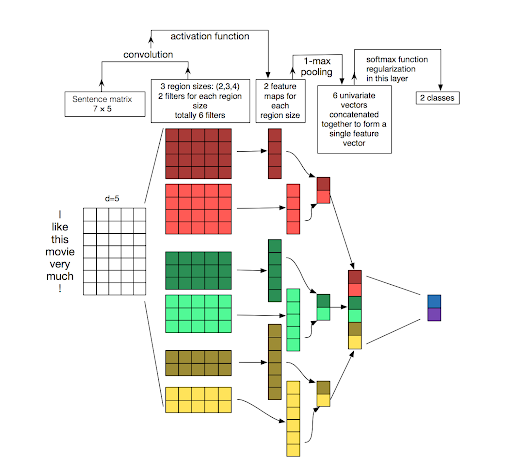

If you previously worked with CNN’s with machine vision tasks, this part could seem similar to you. In input we have word embeddings which is essentially 2-dimensional array like images. Difference from machine vision tasks our convolutional filter shapes.  Because taking part of the word vector is meaningless or filters will span the whole size of the embeddings. After passing our corpus from different filters we will concatenate them and pass through a linear layer to obtain desired dimensions. Figure above shows a convolutional network with 6 different filters. 

In PyTorch there are few different conv layer architectures. You are maybe familiar with `Conv2D` module from image processing tasks. Because our text input is one dimensional array, we can also use `Conv1D`. Firstly let’s see the differences between these two modules.

`Conv1D`modules takes 1 or 2 dimensional array as input.  `in_channels` parameters for depth of the 2nd dimension. `kernel_size` parameters determines sizes of the kernel and `out_channels` parameter determines how many filters will be used. Example below uses 2 different filters with 2 kernel size. 

In [ ]:
embedding = nn.Embedding(10, 3)
dum= torch.tensor([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[2,5,6,2,5]])
x= embedding(dum)
print(dum.shape)
print(x.shape)
print(x.transpose(1,2).shape) # if we didnt have batches we could have used rot90()
cvd1 = nn.Conv1d(in_channels=3, out_channels=2,kernel_size=2)
print(cvd1(x.transpose(1,2)).shape)

torch.Size([6, 5])
torch.Size([6, 5, 3])
torch.Size([6, 3, 5])
torch.Size([6, 2, 4])


On the other hand `Conv2D`modules takes 2 or 3 dimensional arras as input.  `in_channels` parameters for depth of the 3rd dimension. `kernel_size` parameters determines sizes of the kernel and `out_channels` parameter determines how many filters will be used. Example below uses 3 different filters with 2x3 size.

In [ ]:
embedding = nn.Embedding(10, 3)
dum= torch.tensor([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[2,5,6,2,5]])
x= embedding(dum)
print(dum.shape)
print(x.shape)
print(x.unsqueeze(1).shape)
cvd1 = nn.Conv2d(in_channels=1, out_channels=2,kernel_size=(2,3))  # in kernel size 2x3, 3 is the embedding dimension
cvd1(x.unsqueeze(1)).shape

torch.Size([6, 5])
torch.Size([6, 5, 3])
torch.Size([6, 1, 5, 3])


torch.Size([6, 2, 4, 1])

To sum up in  1D  convolutional layer we have 1 dimension as an input and second one as depth, on the other hand in 2D convolutional layer we have 2 dimensions as an input and third dimension (in our case 1) as depth. This can be generalized higher dimensional convolutions. 

## Conv1d Network

In [ ]:
class CNN_1D(nn.Module):
    ''' Define network architecture and forward path. '''
    def __init__(self, vocab_size, vector_size, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super().__init__()
        # Create word embeddings from the input words     
        self.embedding = nn.Embedding(vocab_size, vector_size, 
                                      padding_idx = pad_idx)
        
        # Specify convolutions with filters of different sizes (fs)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = vector_size, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes])
        
        # Add a fully connected layer for final predicitons
        self.linear = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        # Drop some of the nodes to increase robustness in training
        self.dropout = nn.Dropout(dropout)
        
        
        
    def forward(self, text):
        '''Forward path of the network.'''       
        # Get word embeddings and formt them for convolutions
        embedded = self.embedding(text).transpose(1,2)
        
        # Perform convolutions and apply activation functions
        conved = [F.relu(conv(embedded)) for conv in self.convs] 
            
        # Pooling layer to reduce dimensionality    
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        # Dropout layer
        cat = self.dropout(torch.cat(pooled, dim = 1))
        return self.linear(cat)

## Setting Network Parameters and Helper Fucntions

In [ ]:
# Vocabulary size
INPUT_DIM = len(TEXT.vocab)

# Vector size (lower-dimensional repr. of each word)
EMBEDDING_DIM = 100

# Number of filters
N_FILTERS = 100

# N-grams that we want to analuze using filters
FILTER_SIZES = [1, 2, 3, 4, 5]

# Output of the linear layer (prob of a negative review)
OUTPUT_DIM = 1

# Proportion of units to drop
DROPOUT = 0.5

# Zero the initial weights of the UNKnown and padding tokens.
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# The string token used as padding. Default: “<pad>”.
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]


In [ ]:
# Helper functions
def accuracy(preds, y):
    """ Return accuracy per batch. """
    correct = (torch.round(torch.sigmoid(preds)) == y).float() 
    return correct.sum() / len(correct)

def epoch_time(start_time, end_time):
    '''Track training time. '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def train(model, iterator, optimizer, criterion):
    '''Train the model with specified data, optimizer, and loss function. '''
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        # Reset the gradient to not use them in multiple passes 
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = accuracy(predictions, batch.label)
        
        # Backprop
        loss.backward()
        
        # Optimize the weights
        optimizer.step()
        
        # Record accuracy and loss
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    '''Evaluate model performance. '''
    epoch_loss = 0
    epoch_acc = 0
    
    # Turm off dropout while evaluating
    model.eval()
    
    # No need to backprop in eval
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def sentiment(model, sentence, min_len = 5):
    '''Predict user-defined review sentiment.'''
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    # Map words to word embeddings
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    # Get predicitons
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

## Training without freezing embeddings

In [ ]:
# Initialize model and load pre-trained embeddings
model = CNN_1D(INPUT_DIM, EMBEDDING_DIM, 
            N_FILTERS, FILTER_SIZES, 
            OUTPUT_DIM, DROPOUT, PAD_IDX)
model.embedding.weight.data.copy_(TEXT.vocab.vectors)

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model = model.to(device)

Because we are working with embeddings, we will update networks initial embeddings with Glove embeddings. 

In [ ]:
# Network optimizer
optimizer = optim.Adam(model.parameters())

# Loss function
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# Training loop
N_EPOCHS = 10

best_valid_loss = float('inf')
val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

for epoch in range(N_EPOCHS):
    
    # Calculate training time
    start_time = time.time()
    
    # Get epoch losses and accuracies 
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Save training metrics
    val_loss.append(valid_loss)
    val_acc.append(valid_acc)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'CNN-model.pt')
    
    print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch:  1 | Epoch Time: 0m 10s
	Train Loss: 0.661 | Train Acc: 60.38%
	 Val. Loss: 0.530 |  Val. Acc: 75.32%
Epoch:  2 | Epoch Time: 0m 10s
	Train Loss: 0.434 | Train Acc: 79.74%
	 Val. Loss: 0.343 |  Val. Acc: 85.50%
Epoch:  3 | Epoch Time: 0m 10s
	Train Loss: 0.308 | Train Acc: 87.15%
	 Val. Loss: 0.303 |  Val. Acc: 87.29%
Epoch:  4 | Epoch Time: 0m 10s
	Train Loss: 0.223 | Train Acc: 91.25%
	 Val. Loss: 0.288 |  Val. Acc: 87.73%
Epoch:  5 | Epoch Time: 0m 10s
	Train Loss: 0.158 | Train Acc: 94.06%
	 Val. Loss: 0.293 |  Val. Acc: 87.80%
Epoch:  6 | Epoch Time: 0m 10s
	Train Loss: 0.106 | Train Acc: 96.20%
	 Val. Loss: 0.310 |  Val. Acc: 87.77%
Epoch:  7 | Epoch Time: 0m 10s
	Train Loss: 0.073 | Train Acc: 97.65%
	 Val. Loss: 0.352 |  Val. Acc: 87.80%
Epoch:  8 | Epoch Time: 0m 10s
	Train Loss: 0.047 | Train Acc: 98.54%
	 Val. Loss: 0.373 |  Val. Acc: 87.31%
Epoch:  9 | Epoch Time: 0m 10s
	Train Loss: 0.035 | Train Acc: 98.99%
	 Val. Loss: 0.400 |  Val. Acc: 87.18%
Epoch: 10 | Epoch T

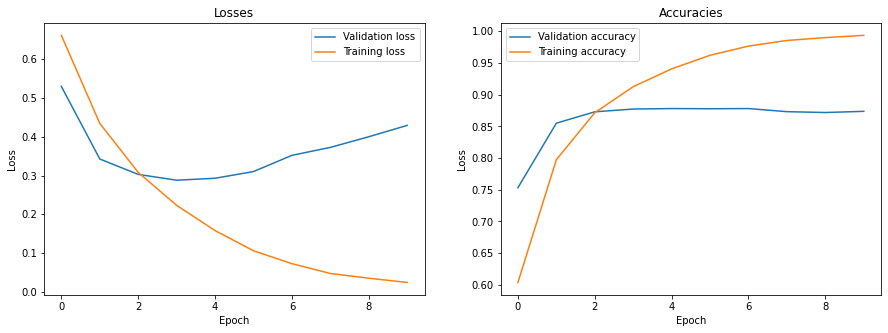

In [ ]:
# Plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(val_loss, label='Validation loss')
ax[0].plot(tr_loss, label='Training loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(val_acc, label='Validation accuracy')
ax[1].plot(tr_acc, label='Training accuracy')
ax[1].set_title('Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate model on test data
model.load_state_dict(torch.load('CNN-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.336 | Test Acc: 85.67%


In [ ]:
reviews = ['This is the best movie I have ever watched!', 
           'This is an okay movie', 
           'This was a waste of time! I hated this movie.']
scores = [sentiment(model, review) for review in reviews]
scores

[0.01629464142024517, 0.5957899689674377, 0.9934870004653931]

In [ ]:
tricky_reviews = ['This is not the best movie I have ever watched!', 
           'Some would say it is an okay movie, but I found it terrific.', 
           'This was a waste of time! I did not like this movie.']
scores = [sentiment(model, review) for review in tricky_reviews]
scores

[0.07551899552345276, 0.38483068346977234, 0.9962096214294434]

## Training with freezing embeddings

In [ ]:
# Initialize model and load pre-trained embeddings
model2 = CNN_Text(INPUT_DIM, EMBEDDING_DIM, 
            N_FILTERS, FILTER_SIZES, 
            OUTPUT_DIM, DROPOUT, PAD_IDX)
model2.embedding.weight.data.copy_(TEXT.vocab.vectors)

model2.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model2.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model2 = model2.to(device)

In [ ]:
model2.embedding.requires_grad = False

Because we are working with embeddings, we will update networks initial embeddings with Glove embeddings. On the other hand, in this part, we will freeze the embedding weights by setting `requires_grad` parameters `False`. Using this network will not calculate the gradients of embedding layer. Although in our example it does not provide a big difference, while using more complex embedding models like Bert it will reduce network parameters significantly.

In [ ]:
# Network optimizer
optimizer = optim.Adam(model2.parameters())

# Loss function
criterion = nn.BCEWithLogitsLoss()

model2 = model2.to(device)
criterion = criterion.to(device)

In [ ]:
# Training loop
N_EPOCHS = 10

best_valid_loss2 = float('inf')
val_loss2 = []
val_acc2 = []
tr_loss2 = []
tr_acc2 = []

for epoch in range(N_EPOCHS):
    
    # Calculate training time
    start_time = time.time()
    
    # Get epoch losses and accuracies 
    train_loss2, train_acc2 = train(model2, train_iterator, optimizer, criterion)
    valid_loss2, valid_acc2 = evaluate(model2, valid_iterator, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Save training metrics
    val_loss2.append(valid_loss2)
    val_acc2.append(valid_acc2)
    tr_loss2.append(train_loss2)
    tr_acc2.append(train_acc2)
    
    if valid_loss2 < best_valid_loss2:
        best_valid_loss2 = valid_loss2
        torch.save(model2.state_dict(), 'CNN-model2.pt')
    
    print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss2:.3f} | Train Acc: {train_acc2*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss2:.3f} |  Val. Acc: {valid_acc2*100:.2f}%')

Epoch:  1 | Epoch Time: 0m 10s
	Train Loss: 0.654 | Train Acc: 60.99%
	 Val. Loss: 0.496 |  Val. Acc: 78.87%
Epoch:  2 | Epoch Time: 0m 10s
	Train Loss: 0.433 | Train Acc: 79.88%
	 Val. Loss: 0.342 |  Val. Acc: 85.77%
Epoch:  3 | Epoch Time: 0m 10s
	Train Loss: 0.315 | Train Acc: 86.69%
	 Val. Loss: 0.313 |  Val. Acc: 86.73%
Epoch:  4 | Epoch Time: 0m 10s
	Train Loss: 0.222 | Train Acc: 91.35%
	 Val. Loss: 0.293 |  Val. Acc: 87.51%
Epoch:  5 | Epoch Time: 0m 10s
	Train Loss: 0.160 | Train Acc: 93.95%
	 Val. Loss: 0.303 |  Val. Acc: 87.56%
Epoch:  6 | Epoch Time: 0m 10s
	Train Loss: 0.106 | Train Acc: 96.32%
	 Val. Loss: 0.313 |  Val. Acc: 87.71%
Epoch:  7 | Epoch Time: 0m 10s
	Train Loss: 0.074 | Train Acc: 97.76%
	 Val. Loss: 0.342 |  Val. Acc: 87.63%
Epoch:  8 | Epoch Time: 0m 10s
	Train Loss: 0.051 | Train Acc: 98.28%
	 Val. Loss: 0.407 |  Val. Acc: 86.93%
Epoch:  9 | Epoch Time: 0m 10s
	Train Loss: 0.034 | Train Acc: 99.01%
	 Val. Loss: 0.400 |  Val. Acc: 87.58%
Epoch: 10 | Epoch T

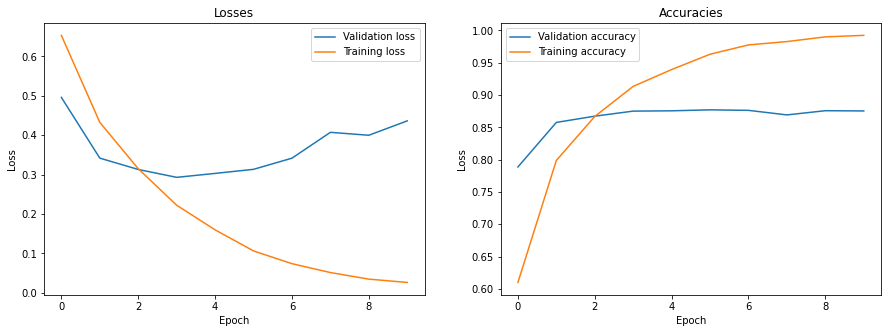

In [ ]:
# Plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(val_loss2, label='Validation loss')
ax[0].plot(tr_loss2, label='Training loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(val_acc2, label='Validation accuracy')
ax[1].plot(tr_acc2, label='Training accuracy')
ax[1].set_title('Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate model on test data
model2.load_state_dict(torch.load('CNN-model2.pt'))

test_loss2, test_acc2 = evaluate(model2, test_iterator, criterion)

print(f'Test Loss: {test_loss2:.3f} | Test Acc: {test_acc2*100:.2f}%')

Test Loss: 0.340 | Test Acc: 85.39%


In [ ]:
reviews = ['This is the best movie I have ever watched!', 
           'This is an okay movie', 
           'This was a waste of time! I hated this movie.']
scores = [sentiment(model2, review) for review in reviews]
scores

[0.027793679386377335, 0.4837534427642822, 0.9783263206481934]

In [ ]:
tricky_reviews = ['This is not the best movie I have ever watched!', 
           'Some would say it is an okay movie, but I found it terrific.', 
           'This was a waste of time! I did not like this movie.']
scores = [sentiment(model2, review) for review in tricky_reviews]
scores

[0.10617011040449142, 0.27976658940315247, 0.9901266098022461]

## Conv2D network

Creating a network with `Conv2d`module is similar to network we explored above. In this module we are considering our input like an `Grayscale image`.  We need to carefully resize our data between layers to conform the next layer input requirement.

In [ ]:
class CNN_Text(nn.Module):
    ''' Define network architecture and forward path. '''
    def __init__(self, vocab_size, vector_size, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super().__init__()
        # Create word embeddings from the input words     
        self.embedding = nn.Embedding(vocab_size, vector_size, 
                                      padding_idx = pad_idx)
        
        # Specify convolutions with filters of different sizes (fs)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, vector_size)) 
                                    for fs in filter_sizes])
        
        # Add a fully connected layer for final predicitons
        self.linear = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        # Drop some of the nodes to increase robustness in training
        self.dropout = nn.Dropout(dropout)
        
        
        
    def forward(self, text):
        '''Forward path of the network.'''       
        # Get word embeddings and formt them for convolutions
        embedded = self.embedding(text).unsqueeze(1)
        
        # Perform convolutions and apply activation functions
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        # Pooling layer to reduce dimensionality    
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        # Dropout layer
        cat = self.dropout(torch.cat(pooled, dim = 1))
        return self.linear(cat)

# A Remark 


`BucketIterator` method pads input parameters according to max length in the batch. So our input sizes differ from each other in each batch (max of 2789 and average of 1038 words). Where and how the network manages this different input?


### Answer

It is done at pooling layer setting pooling size to length of the array it gives equal sized outputs.

Please note that whole network an be set to fixed size setting  `Field` functions `fix_length` parameter.

# Recomended References


* If you are having troble understanding differences between 1D and 2D convolutions, I suggest you can explore [stack exchange post] (https://stats.stackexchange.com/questions/292751/is-a-1d-convolution-of-size-m-with-k-channels-the-same-as-a-2d-convolution-o/292791) and [Intro to CNN blog post](https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29).